In [6]:
from gym import Env
from gym.spaces import Discrete, Box
from numpy import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
class GridWorldEnv(Env):
    '''
    Class defining a general Grid World environment.

    The grid is 'height' by 'width', and each square corresponds to an integer index between 0 and height*width-1.
    The agent starts at 0 and tries to go to height*width-1.
    If the step takes the agent out of bounds, the agent stays in its place.
    At each non-terminating step taken, the agent receives a reward of -12 or +10 with equal probability.
    Upon reaching the target state, the next step the agent takes will give it a reward of +5, and the episode will end.

    Observation space: {0, 1, ..., height*width-1}, corresponding to the squares in the grid
    Action space: {0, 1, 2, 3}, corresponding to {UP, LEFT, RIGHT, DOWN}
    '''

    UP = 0
    LEFT = 1
    RIGHT = 2
    DOWN = 3

    def __init__(self, height, width):
        self.action_space = Discrete(4)
        self.height = height
        self.width = width
        self.observation_space = Discrete(self.height * self.width)
        # initial state
        self.state = 0
        self.end_state = self.height * self.width - 1

    def step(self, action):
        '''
        Function applying the action to current state.
        If the action makes the agent go out of bounds, the agent remains in the same place.
        '''

        terminated = False

        # sample reward randomly
        if random.binomial(n=1, p=0.5, size=1) == 0:
            reward = -12
        else:
            reward = 10

        # check if currently at target
        if self.state == self.end_state:
            reward = 5
            terminated = True
        
        # otherwise, check action and apply if valid
        elif action == self.UP:
            if self.state + self.width <= self.end_state:
                self.state += self.width
        
        elif action == self.LEFT:
            if self.state % self.width != 0:
                self.state -= 1

        elif action == self.RIGHT:
            if self.state % self.width != self.width - 1:
                self.state += 1

        elif action == self.DOWN:
            if self.state >= self.width:
                self.state -= self.width

        information = {}
        
        return self.state, reward, terminated, information

    def reset(self):
        '''
        Function that resets the environment after termination.
        '''
        self.state = 0
        information = {}

        return self.state, information

    def render(self):
        pass

In [7]:
GAMMA = 0.95 # discount factor was 0.95 for all experiments in the original paper
MAX_STEPS = 10000 # number of steps to trace running average of rewards (10000 in the original paper)

In [8]:
def get_epsilon(n):
    '''
    Function to calculate epsilon based on the number of times a state is visited.
    '''
    return 1 / np.sqrt(n)

In [9]:
def get_lr(n, mode):
    '''
    Function to calculate the learning rate based on the number of times a state-action pair is visited, and the mode.
    '''
    if mode == 1:
        alpha = 1/n
    elif mode == 2:
        alpha = 1/(n**0.8)
    return alpha

In [10]:
def Double_Q_learning(env, n_episodes, mode):
    '''
    Implementation of the Double Q-learning algorithm.
    '''
    
    # create Q_a, Q_b tables
    Q_a = np.zeros((env.observation_space.n, env.action_space.n))
    Q_b = np.zeros((env.observation_space.n, env.action_space.n))

    # variables to keep track of reward running average for first MAX_STEPS number of steps
    running_avg_per_step = []
    running_avg = 0
    total_steps_taken = 0

    # variables to keep track of max Q(S,a) for the starting state over all episodes
    running_avg_max_Q_per_step = []
    running_avg_max_Q = 0

    for episode in tqdm(range(n_episodes)):

        # for double Q-learning, as the original paper states, the variable used for the learning rate is:
        # n(s,a) = n_a(s,a) if Q_a is updated
        # otherwise, n(s,a) = n_b(s,a)
        n_s_a_Qa = np.zeros((env.observation_space.n, env.action_space.n))
        n_s_a_Qb = np.zeros((env.observation_space.n, env.action_space.n))

        # keep track of number of times a state is visited (used to calculate epislon)
        n_s = np.zeros(env.observation_space.n)

        # keep track of number of times a state-action pair is visited (used to calculate alpha)
        n_s_a = np.zeros((env.observation_space.n, env.action_space.n))
        
        # reset env
        state, _ = env.reset()

        # update n_s for initial state
        n_s[state] += 1

        # for starting state: get maximal Q value, get running average
        max_starting_Q_a = np.max(Q_a[state])
        max_starting_Q_b = np.max(Q_a[state])
        max_starting_Q = max_starting_Q_a if max_starting_Q_a > max_starting_Q_b else max_starting_Q_b
        running_avg_max_Q = (total_steps_taken * running_avg_max_Q + max_starting_Q) / (total_steps_taken + 1)
        running_avg_max_Q_per_step.append(running_avg_max_Q)

        terminated = False

        while not terminated:
            
            # epsilon-greedy exploration
            epsilon = get_epsilon(n_s[state])
            
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                # get action with maximal Q value per Double Q-learning
                Q = Q_a[state] + Q_b[state]
                max = np.where(np.max(Q) == Q)[0]
                action = np.random.choice(max)

            # apply action, get reward
            next_state, reward, terminated, _ = env.step(action)
            
            # update n_s for new state
            n_s[next_state] += 1

            # update n_s_a for (state, action)
            n_s_a[state, action] += 1

            # update A or B with equal probability
            if np.random.rand() < 0.5:
                # update Q_a
                # increment count for (state, action) pair matrix for Qa
                n_s_a_Qa[state, action] = n_s_a_Qa[state, action] + 1
                # get alpha
                alpha = get_lr(n_s_a_Qa[state, action], mode)
                c = alpha * (reward + GAMMA * Q_b[next_state, np.argmax(Q_a[next_state])] - Q_a[state, action])
                Q_a[state, action] = Q_a[state, action] + c
            else:
                # update Q_b
                # increment count for (state, action) pair matrix for Qb
                n_s_a_Qb[state, action] = n_s_a_Qb[state, action] + 1
                # get alpha
                alpha = get_lr(n_s_a_Qb[state, action], mode)
                c = alpha * (reward + GAMMA * Q_a[next_state, np.argmax(Q_b[next_state])] - Q_b[state, action])
                Q_b[state, action] = Q_b[state, action] + c

            # update state to be next state
            state = next_state

            # calculate running average of rewards for first MAX_STEPS steps
            if total_steps_taken < MAX_STEPS:
                running_avg = (total_steps_taken * running_avg + reward) / (total_steps_taken + 1)
                running_avg_per_step.append(running_avg)
                
            total_steps_taken += 1

    return running_avg_per_step, running_avg_max_Q_per_step

In [15]:
def plot_graphs(Double_Q_learning_mode_1_running_avg_per_step_3x3, 
                Double_Q_learning_mode_2_running_avg_per_step_3x3,
                Double_Q_learning_mode_1_running_avg_max_Q_per_step_3x3,
                Double_Q_learning_mode_2_running_avg_max_Q_per_step_3x3,
                title):
    fig, axs = plt.subplots(2, 2)

    fig.suptitle(title)

    axs[0, 0].set_title(r'$\alpha = 1/n(s,a)$')
    axs[0, 0].plot(np.arange(MAX_STEPS), Double_Q_learning_mode_1_running_avg_per_step_3x3, linewidth=1)
    axs[0, 0].set_xlim(0, 10000)
    axs[0, 0].set_ylim(-1.5, 0.5)
    axs[0, 0].set_ylabel(r'$r$ per step')
    axs[0, 0].legend()

    axs[0, 1].set_title(r'$\alpha = 1/n(s,a)^{0.8}$')
    axs[0, 1].plot(np.arange(MAX_STEPS), Double_Q_learning_mode_2_running_avg_per_step_3x3, linewidth=1)
    axs[0, 1].set_xlim(0, 10000)
    axs[0, 1].set_ylim(-1.5, 0.5)

    axs[1, 0].set_ylabel(r'$max_{a} Q(S, a)$')
    axs[1, 0].set_xlabel('Number of steps')
    axs[1, 0].plot(np.arange(MAX_STEPS), Double_Q_learning_mode_1_running_avg_max_Q_per_step_3x3, linewidth=1)
    axs[1, 0].set_xlim(0, 10000)

    axs[1, 1].set_xlabel('Number of steps')
    axs[1, 1].plot(np.arange(MAX_STEPS), Double_Q_learning_mode_2_running_avg_max_Q_per_step_3x3, linewidth=1)
    axs[1, 1].set_xlim(0, 10000)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2041.39it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


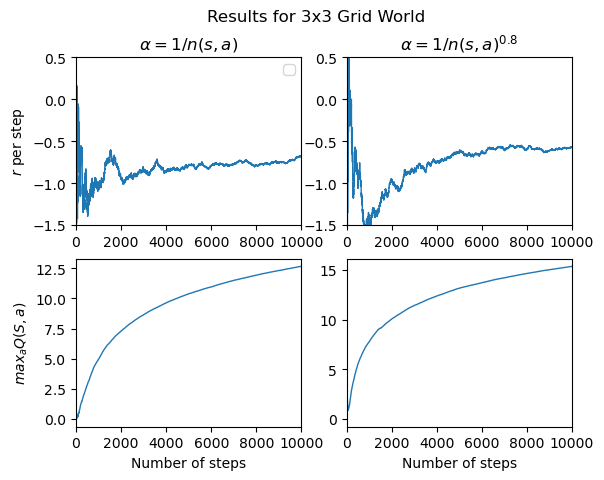

In [16]:
env3x3 = GridWorldEnv(height=3, width=3)

Double_Q_learning_mode_1_running_avg_per_step_3x3, Double_Q_learning_mode_1_running_avg_max_Q_per_step_3x3 = Double_Q_learning(env=env3x3, n_episodes=10000, mode=1)
Double_Q_learning_mode_2_running_avg_per_step_3x3, Double_Q_learning_mode_2_running_avg_max_Q_per_step_3x3 = Double_Q_learning(env=env3x3, n_episodes=10000, mode=2)

plot_graphs(Double_Q_learning_mode_1_running_avg_per_step_3x3, 
                Double_Q_learning_mode_2_running_avg_per_step_3x3,
                Double_Q_learning_mode_1_running_avg_max_Q_per_step_3x3,
                Double_Q_learning_mode_2_running_avg_max_Q_per_step_3x3,
                'Results for 3x3 Grid World')